In [73]:
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import euclidean
from dice_ml import Data, Model, Dice
import warnings
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
import seaborn as sns

In [3]:
import metrics #file with framwework implementation functions

In [4]:
# Suppress warnings - commenting this when actually running the code might be useful - doing it now to look good in the notebook
warnings.filterwarnings("ignore", category=UserWarning)

## Prepare dataset, model & explainers

In [5]:
# Load Pima Diabetes dataset - TABULAR dataset used to exemplify
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)
data['Outcome'] = pd.Categorical(data['Outcome'], categories=[0, 1], ordered=True)
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age Outcome  
0                     0.627   50       1  
1                     0.351   31       0  
2                     0.672   32       1  
3                     0.167   21       0  
4                     2.288   33       1

In [6]:
# Preprocess data
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(len(X_test))
print(len(X_train))

154
614


In [7]:
# Train model - training a Random Forest just as an example
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [ ]:
# Initialize LIME
lime_explainer = LimeTabularExplainer(X_train.values, mode='classification', training_labels=y_train, feature_names=X.columns,
                                      class_names= ['no diabetes', 'diabetes'])

# Initialize SHAP
kernel_shap_explainer = shap.KernelExplainer(model.predict_proba, X_train) # the warning is coming from here, because kernelSHAP is slow
tree_shap_explainer = shap.TreeExplainer(model)

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Create explanations for the first test instance

In [9]:
instance = X_test.iloc[0].values.reshape(1, -1)
print(X_test.iloc[0])
print(y_test.iloc[0]) # true label is 0 - no diabetes

Pregnancies                   6.00
Glucose                      98.00
BloodPressure                58.00
SkinThickness                33.00
Insulin                     190.00
BMI                          34.00
DiabetesPedigreeFunction      0.43
Age                          43.00
Name: 668, dtype: float64
0


In [10]:
model.predict_proba(X_test.iloc[0:1]) # prediction for no diabetes is 0.69 - ok

array([[0.69, 0.31]])

LIME explanation

In [11]:
# Lime explanation
lime_explanation = lime_explainer.explain_instance(instance[0], model.predict_proba, num_features=7)
lime_explanation.show_in_notebook()

In [12]:
lime_explanation.local_pred[0] # Diabetes prediction is 0.42 (true one is 0.31)

0.42379676432894486

In [13]:
lime_explanation.score #r2 of surrogate model - a low score suggests that the surrogate model may not be capturing the black-box model's behavior accurately

0.2713997764188947

In [14]:
lime_explanation.as_list()

[('Glucose <= 100.00', -0.2108471832303432),
 ('Age > 40.00', 0.12297923813972773),
 ('32.00 < BMI <= 36.38', 0.0751543444902338),
 ('BloodPressure <= 64.00', 0.027783417298293873),
 ('0.37 < DiabetesPedigreeFunction <= 0.61', 0.017564165520621473),
 ('SkinThickness > 32.00', 0.01668879600655879),
 ('3.00 < Pregnancies <= 6.00', 0.0072379875546667305)]

KernelSHAP explanation

In [15]:
# Kernel SHAP explanation
kernel_shap_values = kernel_shap_explainer(instance)
shap.initjs()
# Showing explanation for diabetes probability
shap.force_plot(kernel_shap_explainer.expected_value[1], kernel_shap_values.values[:,:,1], instance, feature_names=X.columns)

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


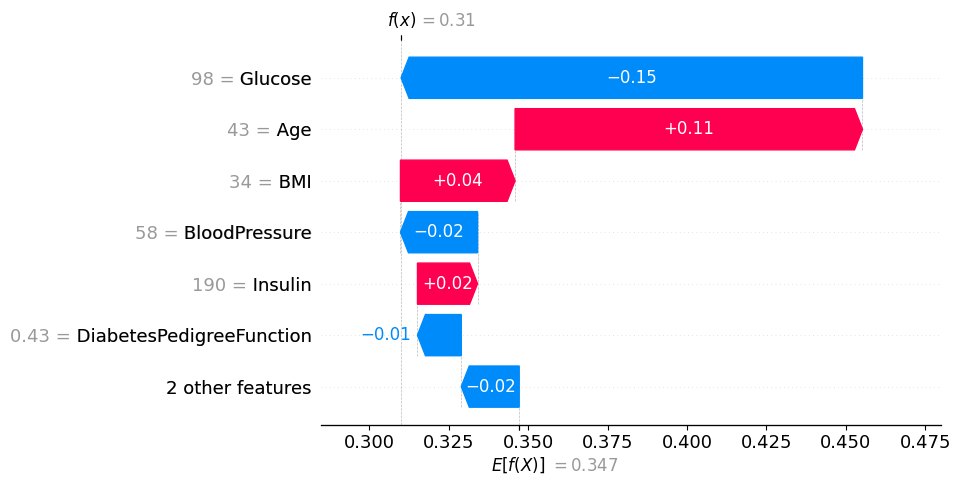

In [16]:
shap.plots.waterfall(kernel_shap_values[:,:,1][0], max_display=7)

TreeSHAP explanation

In [17]:
# Tree SHAP explanation
tree_shap_values = tree_shap_explainer(instance)
shap.force_plot(tree_shap_values[:,:,1],feature_names=X.columns)

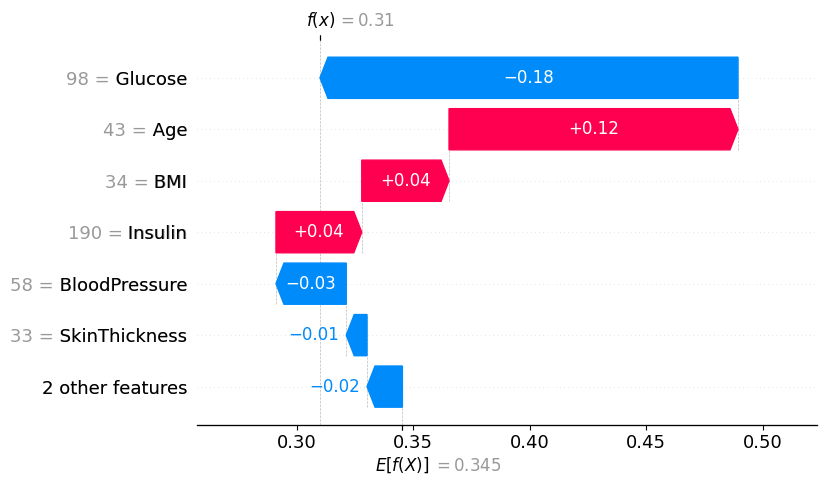

In [18]:
shap_values = tree_shap_explainer(X_test)
shap.plots.waterfall(shap_values[:,:,1][0], max_display=7)

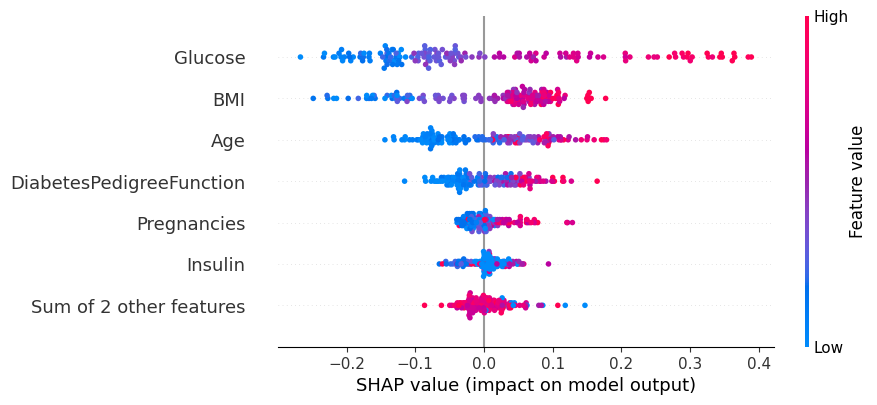

In [19]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=7)

In [20]:
# Get global explanation
shap_values_global = tree_shap_explainer(X_train)

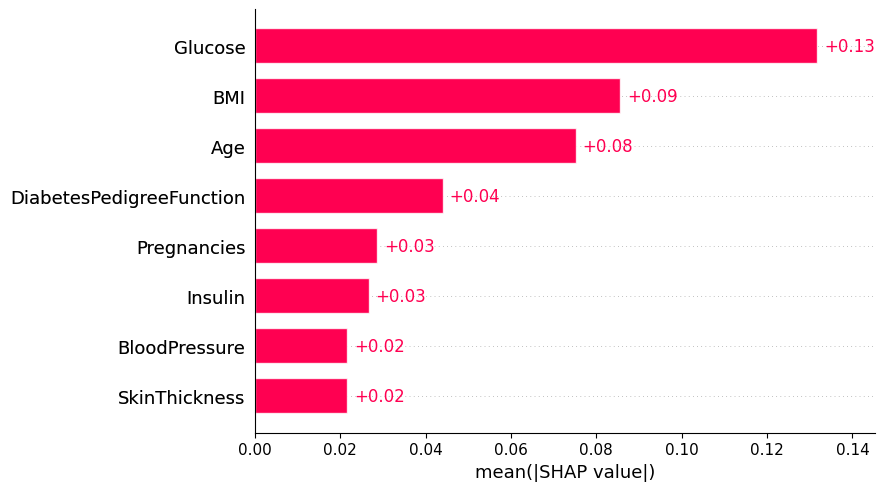

In [21]:
shap.plots.bar(shap_values_global[:,:,1])

## Framework example use

### F1 - Representativeness

All sub-properties here have fixed metrics, meaning they are case-independent.

#### F1.1 - Scope

In [22]:
scope = {"LIME": 2, "KernelSHAP": 2, "TreeSHAP": 3}
# LIME provides local explanations
# KernelSHAP provides local explanations
# TreeSHAP supports global and local

#### F1.2 - Portability

In [23]:
portability = {"LIME": 2, "KernelSHAP": 2, "TreeSHAP": 1}
# LIME is model-agnostic; works with any black-box model.
# KernelShap similar to LIME
# TreeSHAP specific to tree-based models

#### F1.3 - Access

In [24]:
access_lime = {"Data Access": 2, "Model Access": 2}  
# Needs data for initialization only (creating an explainer object) & requires access to the model’s prediction function
access_kernel_shap = {"Data Access": 2, "Model Access": 2}  
# Similar to LIME
access_tree_shap = {"Data Access": 3, "Model Access": 0}  
# No data required if applied to tree-based models directly & requires full model access

access = {"LIME": 4, "KernelSHAP": 4, "TreeSHAP": 3}  # Sum of Data Access and Model Access

#### F1.4 - Practicality

In [25]:
practicality_lime = {"Applicability": 2, "Scalability": 1}  
# Data-agnostic, moderately scalable (computationally expensive for large datasets)
practicality_kernel_shap = {"Applicability": 2, "Scalability": 0}  
# Data-agnostic & impractical for large datasets
practicality_tree_shap = {"Applicability": 1, "Scalability": 2}  
# Data-specific but highly scalable (efficient for large datasets)
# It does not naturally extend to unstructured data like images or text without converting them into tabular representations 
# (e.g., embeddings, feature extraction)

practicality = {"LIME": 3, "KernelSHAP": 2, "TreeSHAP": 3}  
# Sum of Applicability and Scalability

#### F1 Summary table

In [26]:
# Calculate total scores
total_repr = {key: scope[key] + portability[key] + access[key] + practicality[key] for key in scope}

In [27]:
f1 = pd.DataFrame({
    "Scope (F1.1)": [scope["LIME"], scope["KernelSHAP"], scope["TreeSHAP"]],
    "Portability (F1.2)": [portability["LIME"], portability["KernelSHAP"], portability["TreeSHAP"]],
    "Access (F1.3)": [access["LIME"], access["KernelSHAP"], access["TreeSHAP"]],
    "Practicality (F1.4)": [practicality["LIME"], practicality["KernelSHAP"], practicality["TreeSHAP"]],
    "Total": [total_repr["LIME"], total_repr["KernelSHAP"], total_repr["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f1

Scope (F1.1)  Portability (F1.2)  Access (F1.3)  \
LIME                   2                   2              4   
KernelSHAP             2                   2              4   
TreeSHAP               3                   1              3   

            Practicality (F1.4)  Total  
LIME                          3     11  
KernelSHAP                    2     10  
TreeSHAP                      3     10

### F2 - Structure

#### F2.1 - Expressive Power 

data type-dependent (and user)

In [28]:
# Predefined set of comprehensible formats - this is an example, to be updated based on user studies and/or user needs
C = {"decision_tree", "text_summary", "causal_diagram", "bar_plot", "analogy", "rule"}

In [29]:
# LIME parameters
n_lime = 1  # One explanatory output: feature influence
F_lime = ["table_summary", "bar_plot", "rule"] #It has rule in the terms of if feature_1 < 10, class = 1
score_lime = metrics.f2_1(n_lime, F_lime, C)
print(f"LIME Expressive Power Score: {score_lime}")
# KernelSHAP parameters
n_kernelshap = 1  # One explanatory output: Shapley values
F_kernelshap = ["bar_plot"]  
score_kernelshap = metrics.f2_1(n_kernelshap, F_kernelshap, C)
print(f"KernelSHAP Expressive Power Score: {score_kernelshap}")

# TreeSHAP parameters
n_treeshap = 1  # One explanatory output: Shapley values
F_treeshap = ["bar_plot", "interaction_plot", "beeswarm_plot"] 
score_treeshap = metrics.f2_1(n_treeshap, F_treeshap, C)
print(f"TreeSHAP Expressive Power Score: {score_treeshap}")

# Assign
expressive_power = {"LIME": score_lime, "KernelSHAP": score_kernelshap, "TreeSHAP": score_treeshap}

LIME Expressive Power Score: 4.7
KernelSHAP Expressive Power Score: 3.0
TreeSHAP Expressive Power Score: 4.3


#### F2.2 - Graphical Integrity
Data type-dependent - because positive/negative distinction changes if we are looking at a bar plot, heatmap, etc.

In [30]:
graphical_integrity = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# They all show a positive/negative distinction with color-coded bars in tabular domain

#### F2.3 - Morphological Clarity

In [31]:
morphological_clarity = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# In all of them, longer bars indicate more relevant features in tabular domain

#### F2.4 - Layer Separation

In [32]:
layer_separation = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# In all of them, the feature values of the input instance are visible

#### F2 Summary table

In [33]:
# Calculate total scores
total_structure = {key: expressive_power[key] + graphical_integrity[key] + morphological_clarity[key] + layer_separation[key] for key in expressive_power}

In [34]:
f2 = pd.DataFrame({
    "Expressive Power (F2.1)": [expressive_power["LIME"], expressive_power["KernelSHAP"], expressive_power["TreeSHAP"]],
    "Graphical Integrity (F2.2)": [graphical_integrity["LIME"], graphical_integrity["KernelSHAP"], graphical_integrity["TreeSHAP"]],
    "Morphological Clarity (F2.3)": [morphological_clarity["LIME"], morphological_clarity["KernelSHAP"], morphological_clarity["TreeSHAP"]],
    "Layer Separation (F2.4)": [layer_separation["LIME"], layer_separation["KernelSHAP"], layer_separation["TreeSHAP"]],
    "Total": [total_structure["LIME"], total_structure["KernelSHAP"], total_structure["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f2

Expressive Power (F2.1)  Graphical Integrity (F2.2)  \
LIME                            4.7                           1   
KernelSHAP                      3.0                           1   
TreeSHAP                        4.3                           1   

            Morphological Clarity (F2.3)  Layer Separation (F2.4)  Total  
LIME                                   1                        1    7.7  
KernelSHAP                             1                        1    6.0  
TreeSHAP                               1                        1    7.3

### F3 - Selectivity

It depends on the Dataset, as $s$ changes according to it. A tabular dataset might have 100 input feature, for example.

In [36]:
explanation_size = {"LIME": metrics.f3(s=8, tunable = True), "KernelSHAP": metrics.f3(s=8, tunable = True), "TreeSHAP": metrics.f3(s=8,tunable = True)}
# In this case, both LIME and SHAP allow us to choose a max number of features to display, but there are certain methods that do not allow (e.g., PFI)

In [39]:
# Example of the metric for when tunable = False
metrics.f3(s=8, tunable=False)

0.9

In [40]:
f3 = pd.DataFrame({
    "Total": [explanation_size["LIME"], explanation_size["KernelSHAP"], explanation_size["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f3

Total
LIME          1.0
KernelSHAP    1.0
TreeSHAP      1.0

### F4 - Contrastivity

#### F4.1 - Contrastivity Level

In [41]:
contrastivity_level = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# All are contrastive to a predefined baseline, which is the average value
# PDP, for example, simply show importance scores - score is 0
# CIU, for example, is contrastive to a predefined baseline (which can be chosen as the average or an other prediction) and to 
# the current instance (like counterfactual explanations) - score is 2

#### F4.2 - Target Sensitivity

Step 1: Initialize DiCE for Counterfactuals

In [42]:
# Step 1: Initialize DiCE for Counterfactuals
data_dice = Data(dataframe=data, continuous_features=X.columns.tolist(), outcome_name='Outcome')
model_dice = Model(model=model, backend='sklearn')
dice = Dice(data_dice, model_dice)

Step 2: Generate Nearest Counterfactual for test instance 0

In [43]:
# Step 2: Generate Nearest Counterfactual
query_instance = X_test.iloc[0:1]  # Original instance
counterfactual = dice.generate_counterfactuals(query_instance, total_CFs=1, desired_class="opposite")
cf_instance = counterfactual.cf_examples_list[0].final_cfs_df.drop('Outcome', axis=1)

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Step 3: Generate explanations for all instances in the dataset and compute d_max

In [44]:
# LIME
# Generate Explanations for 100 (just to have an idea) Instances in the Dataset
lime_values = []
for i in range(100):
    exp = lime_explainer.explain_instance(X_train.iloc[i].values, model.predict_proba)
    lime_values.append([v for _, v in exp.as_list()])

# Compute Pairwise Distances and d_max
lime_distances = euclidean_distances(lime_values)
d_max_lime = np.max(lime_distances)
print(round(d_max_lime,1))

0.7


In [45]:
# LIME
lime_exp_1 = lime_explainer.explain_instance(query_instance.values[0], model.predict_proba)
lime_values_1 = [v for _, v in lime_exp_1.as_list()]

lime_exp_2 = lime_explainer.explain_instance(cf_instance.values[0], model.predict_proba)
lime_values_2 = [v for _, v in lime_exp_2.as_list()]

# Compute Target Sensitivity (F4.2)
lime_f4_2 = metrics.f4_2(lime_values_1, lime_values_2, d_max=d_max_lime, distance_metric=euclidean)  # Use dataset-specific d_max for normalization
print("LIME Target Sensitivity (F4.2) Score:", lime_f4_2)

LIME Target Sensitivity (F4.2) Score: 0.1


In [46]:
# Kernel SHAP
# Generate SHAP Values for 100 (just to have an idea) Instances in the Dataset - this takes a while because it is kernelSHAP
kernel_shap_values = []
for i in range(100):
    exp = kernel_shap_explainer(X_train.iloc[i])
    kernel_shap_values.append(exp.values[:,0])

# Compute Pairwise Distances and d_max
kernel_shap_distances = euclidean_distances(kernel_shap_values)
d_max_kernel = np.max(kernel_shap_distances)
print(round(d_max_kernel,1))

0.7


In [47]:
# KernelSHAP
kernel_shap_1 = kernel_shap_explainer(query_instance)
kernel_shap_2 = kernel_shap_explainer(cf_instance)

kernel_values_1 = kernel_shap_1.values[:,:,0][0]
kernel_values_2 = kernel_shap_2.values[:,:,0][0]

kernel_f4_2 = metrics.f4_2(kernel_values_1, kernel_values_2, d_max=d_max_kernel, distance_metric=euclidean)
print("KernelSHAP Target Sensitivity (F4.2) Score:", kernel_f4_2)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

KernelSHAP Target Sensitivity (F4.2) Score: 0.2


In [48]:
# Tree SHAP
# Generate SHAP Values for 100 (just to have an idea) Instances in the Dataset - here its is suuuper fast
tree_shap_values = []
for i in range(100):
    exp = tree_shap_explainer(X_train.iloc[i])
    tree_shap_values.append(exp.values[:,0])

# Compute Pairwise Distances and d_max
tree_shap_distances = euclidean_distances(tree_shap_values)
d_max_tree = np.max(tree_shap_distances)
print(round(d_max_tree,1))

0.7


In [49]:
# treeSHAP
tree_shap_1 = tree_shap_explainer(query_instance)
tree_shap_2 = tree_shap_explainer(cf_instance)

tree_values_1 = tree_shap_1.values[:,:,0][0]
tree_values_2 = tree_shap_2.values[:,:,0][0]

tree_f4_2 = metrics.f4_2(tree_values_1, tree_values_2, d_max=d_max_tree, distance_metric=euclidean)
print("treeSHAP Target Sensitivity (F4.2) Score:", tree_f4_2)

treeSHAP Target Sensitivity (F4.2) Score: 0.2


In [50]:
target_sensitivity = {"LIME": lime_f4_2, "KernelSHAP": kernel_f4_2, "TreeSHAP": tree_f4_2}

#### F4 Summary table

In [51]:
# Calculate total scores
total_contrast = {key: contrastivity_level[key] + target_sensitivity[key] for key in contrastivity_level}

In [52]:
f4 = pd.DataFrame({
    "Contrastivity Level (F4.1)": [contrastivity_level["LIME"], contrastivity_level["KernelSHAP"], contrastivity_level["TreeSHAP"]],
    "Target Sensitivity (F4.2)": [target_sensitivity["LIME"], target_sensitivity["KernelSHAP"], target_sensitivity["TreeSHAP"]],
    "Total": [total_contrast["LIME"], total_contrast["KernelSHAP"], total_contrast["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f4

Contrastivity Level (F4.1)  Target Sensitivity (F4.2)  Total
LIME                                 1                        0.1    1.1
KernelSHAP                           1                        0.2    1.2
TreeSHAP                             1                        0.2    1.2

### F5 - Interactivity

These are also fixed metrics, as they are inherent to the XAI method per se

#### F5.1 - Interaction Level

In [53]:
interaction_level = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# In all of them: no built-in interactive tools, but API allows developers to implement interaction easily

#### F5.2 - Controllability

In [54]:
controllability = {"LIME": 2, "KernelSHAP": 2, "TreeSHAP": 2}
# Besides visual exploration, explanations can be refined by choosing specific features or adjusting the number of features shown, offering limited control.

#### F5 Summary Table

In [55]:
# Calculate total scores
total_interactivity = {key: interaction_level[key] + controllability[key] for key in interaction_level}

In [57]:
f5 = pd.DataFrame({
    "Interaction Level (F5.1)": [interaction_level["LIME"], interaction_level["KernelSHAP"], interaction_level["TreeSHAP"]],
    "Controllability (F5.2)": [controllability["LIME"], controllability["KernelSHAP"], controllability["TreeSHAP"]],
    "Total": [total_interactivity["LIME"], total_interactivity["KernelSHAP"], total_interactivity["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f5

Interaction Level (F5.1)  Controllability (F5.2)  Total
LIME                               1                       2      3
KernelSHAP                         1                       2      3
TreeSHAP                           1                       2      3

### F6 - Fidelity

#### F6.1 - Fidelity Check 
(fixed)

In [58]:
fidelity_check = {"LIME": 0, "KernelSHAP": 0, "TreeSHAP": 1}
# Surrogate model or linearity assumptions used in LIME & kernelSHAP with default linear kernel

#### F6.2 - Surrogate Agreement

In [59]:
# Get 100 predictions
bb_preds = model.predict_proba(X_train.iloc[0:100])

In [60]:
# LIME
# Generate Explanations for 100 Instances in the Dataset (Calculate faithfulness over 100)
lime_preds = []
for i in range(100):
    exp = lime_explainer.explain_instance(X_train.iloc[i].values, model.predict_proba)
    # lime computes linear aprox for class 1 - diabetes
    lime_preds.append([exp.local_pred[0]])

# Calculate Surrogate Agreement for LIME - bb preds for class 1
lime_f6_2 = metrics.f6_2(bb_preds[:, 1], lime_preds)
print("LIME Surrogate Agreement (F6.2):", lime_f6_2)

LIME Surrogate Agreement (F6.2): 0.7


In [61]:
# Kernel SHAP
# Generate SHAP Values for 100 Instances in the Dataset - this takes a while because it is kernelSHAP

base_value = kernel_shap_explainer.expected_value[0]  # Base value for class 0

kernel_preds = []
for i in range(100):
    exp = kernel_shap_explainer(X_train.iloc[i])
    surrogate_pred_shap = base_value + sum(exp.values[:,0]) #for class 0
    kernel_preds.append([surrogate_pred_shap])

# Calculate Surrogate Agreement for kernelSHAP - bb preds for class 0
kernel_f6_2 = metrics.f6_2(bb_preds[:, 0], kernel_preds)
print("KernelSHAP Surrogate Agreement (F6.2):", kernel_f6_2)

KernelSHAP Surrogate Agreement (F6.2): 0.6


In [62]:
surrogate_agreement = {"LIME": lime_f6_2, "KernelSHAP": kernel_f6_2, "TreeSHAP": 1}
#TreeSHAP is 1 because no surrogate model is used

#### F6 Summary Table

In [63]:
# Calculate total scores
total_fidelity = {key: fidelity_check[key] + surrogate_agreement[key] for key in fidelity_check}

In [64]:
f6 = pd.DataFrame({
    "Fidelity Check (F6.1)": [fidelity_check["LIME"], fidelity_check["KernelSHAP"], fidelity_check["TreeSHAP"]],
    "Surrogate Agreement (F6.2)": [surrogate_agreement["LIME"], surrogate_agreement["KernelSHAP"], surrogate_agreement["TreeSHAP"]],
    "Total": [total_fidelity["LIME"], total_fidelity["KernelSHAP"], total_fidelity["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f6

Fidelity Check (F6.1)  Surrogate Agreement (F6.2)  Total
LIME                            0                         0.7    0.7
KernelSHAP                      0                         0.6    0.6
TreeSHAP                        1                         1.0    2.0

### F7 - Faithfulness

#### F7.1 - Incremental Deletion 
(use when comparing local methods)

In [65]:
# Get predictions for the test set
probs = model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Select 30 instances where class 1 probability > 0.6
selected_instances = X_test[probs > 0.6].iloc[:30]

In [66]:
# Define a base instance with optimal values for predicting class 0
# Manually defining the base instance
base_instance = {
    'Pregnancies': 0, 
    'Glucose': 70,
    'BloodPressure': 60, 
    'SkinThickness': 15, 
    'Insulin': 80, 
    'BMI': 22.0, 
    'DiabetesPedigreeFunction': 0.1, 
    'Age': 22
}

# Convert to numpy array (to match the format of `instance` in the function)
base_instance_array = np.array([base_instance[feature] for feature in X.columns]).reshape(1, -1)

In [67]:
selected_instances.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
336            0      117              0              0        0  33.8   
568            4      154             72             29      126  31.3   
212            7      179             95             31        0  34.2   
209            7      184             84             33        0  35.5   
120            0      162             76             56      100  53.2   

     DiabetesPedigreeFunction  Age  
336                     0.932   44  
568                     0.338   37  
212                     0.164   60  
209                     0.355   41  
120                     0.759   25

In [68]:
instance_test = selected_instances.iloc[0].values.reshape(1, -1)

# We want predictions for class 1

# LIME
lime_explanation_test = lime_explainer.explain_instance(instance_test[0], model.predict_proba)
# Extract the feature indices
feature_indices = [index for index, _ in lime_explanation_test.as_map()[1]]
# Map the feature indices to feature names
lime_feature_ranking = [X.columns[index] for index in feature_indices]

# KernelSHAP
kernel_shap_test = kernel_shap_explainer(instance_test)
kernel_shap_feature_ranking = np.argsort(-np.abs(kernel_shap_test.values[:,:,1][0]))  # Ranking by absolute Shapley values
kernel_feature_ranking = [X.columns[index] for index in kernel_shap_feature_ranking]

# treeSHAP
tree_shap_test = tree_shap_explainer(instance_test)
tree_shap_feature_ranking = np.argsort(-np.abs(tree_shap_test.values[:,:,1][0]))  # Ranking by absolute Shapley values
tree_feature_ranking = [X.columns[index] for index in tree_shap_feature_ranking]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


In [69]:
print(lime_feature_ranking)
print(kernel_feature_ranking)
print(tree_feature_ranking)

['Age', 'BMI', 'DiabetesPedigreeFunction', 'Glucose', 'Pregnancies', 'BloodPressure', 'Insulin', 'SkinThickness']
['BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'Insulin', 'SkinThickness', 'Glucose', 'Pregnancies']
['BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'SkinThickness', 'Insulin', 'Pregnancies', 'Glucose']


In [70]:
# Perform Incremental Deletion
lime_probs, lime_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, lime_feature_ranking, X)
kernel_probs, kernel_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, kernel_feature_ranking, X)
tree_probs, tree_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, tree_feature_ranking, X)

In [74]:
# Generate a random feature ranking
random_feature_ranking = np.random.permutation(X.columns).tolist()
# Perform Incremental Deletion
random_probs, random_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, random_feature_ranking, X)

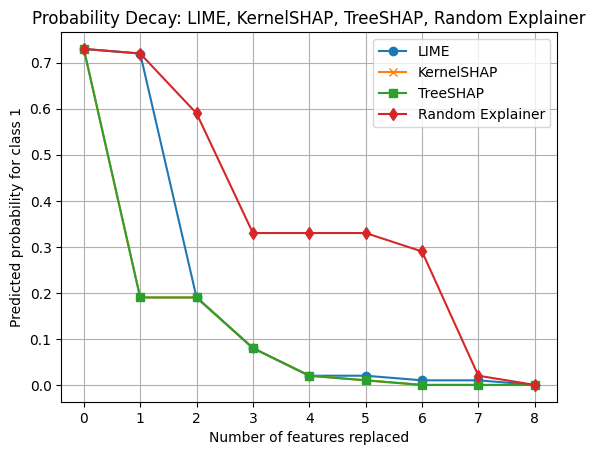

In [75]:
# Plot probability decay curves
plt.plot(range(len(lime_probs)), lime_probs, label='LIME', marker='o')
plt.plot(range(len(kernel_probs)), kernel_probs, label='KernelSHAP', marker='x')
plt.plot(range(len(tree_probs)), tree_probs, label='TreeSHAP', marker='s')
plt.plot(range(len(random_probs)), random_probs, label='Random Explainer', marker='d')

# Customize plot
plt.xlabel('Number of features replaced')
plt.ylabel('Predicted probability for class 1')
plt.title('Probability Decay: LIME, KernelSHAP, TreeSHAP, Random Explainer')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# Metric for just one instance
print("F7.1 for LIME (single instance):", metrics.f7_1_result(lime_auc, random_auc))
print("F7.1 for kernelSHAP (single instance):", metrics.f7_1_result(kernel_auc, random_auc))
print("F7.1 for treeSHAP (single instance):", metrics.f7_1_result(tree_auc, random_auc))

F7.1 for LIME (single instance): 0.5
F7.1 for kernelSHAP (single instance): 0.7
F7.1 for treeSHAP (single instance): 0.7


In [82]:
# Now for N=30 selected instances:

# Initialize lists to store AUC differences for each method
lime_scores_auc = []
kernel_scores_auc = []
tree_scores_auc = []

# Loop over all instances in selected_instances
for index, row in selected_instances.iterrows():
    instance_test = row.values.reshape(1, -1)
    
    # LIME feature ranking
    lime_explanation_test = lime_explainer.explain_instance(instance_test[0], model.predict_proba)
    feature_indices = [index for index, _ in lime_explanation_test.as_map()[1]]
    lime_feature_ranking = [X.columns[index] for index in feature_indices]
    
    # KernelSHAP feature ranking
    kernel_shap_test = kernel_shap_explainer(instance_test, silent=True)
    kernel_shap_feature_ranking = np.argsort(-np.abs(kernel_shap_test.values[:,:,1][0]))
    kernel_feature_ranking = [X.columns[index] for index in kernel_shap_feature_ranking]
    
    # TreeSHAP feature ranking
    tree_shap_test = tree_shap_explainer(instance_test)
    tree_shap_feature_ranking = np.argsort(-np.abs(tree_shap_test.values[:,:,1][0]))
    tree_feature_ranking = [X.columns[index] for index in tree_shap_feature_ranking]
    
    # Random feature ranking
    random_feature_ranking = np.random.permutation(X.columns).tolist()
    
    # Perform Incremental Deletion
    lime_probs, lime_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, lime_feature_ranking, X)
    kernel_probs, kernel_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, kernel_feature_ranking, X)
    tree_probs, tree_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, tree_feature_ranking, X)
    random_probs, random_auc = metrics.f7_1_get_probs_auc(model, instance_test[0], base_instance_array, random_feature_ranking, X)
    
    # Calculate normalized F7.1 scores
    lime_scores_auc.append(metrics.f7_1_result(lime_auc, random_auc))
    kernel_scores_auc.append(metrics.f7_1_result(kernel_auc, random_auc))
    tree_scores_auc.append(metrics.f7_1_result(tree_auc, random_auc))

In [83]:
# Compute Incremental Deletion F7.1 scores
incremental_deletion_lime = round(np.mean(lime_scores_auc),1)
incremental_deletion_kernel = round(np.mean(kernel_scores_auc),1)
incremental_deletion_tree = round(np.mean(tree_scores_auc),1)

# Print results
print("Incremental Deletion F7.1 Score (LIME):", incremental_deletion_lime)
print("Incremental Deletion F7.1 Score (KernelSHAP):", incremental_deletion_kernel)
print("Incremental Deletion F7.1 Score (TreeSHAP):", incremental_deletion_tree)

# Score 0: : The XAI method performs no better than random feature selection.
# Score 1: The XAI method perfectly identifies the most impactful features, leading to a steeper probability decay than the random explainer.

Incremental Deletion F7.1 Score (LIME): 0.4
Incremental Deletion F7.1 Score (KernelSHAP): 0.5
Incremental Deletion F7.1 Score (TreeSHAP): 0.5


In [84]:
incremental_deletion = {"LIME": incremental_deletion_lime, "KernelSHAP": incremental_deletion_kernel, "TreeSHAP": incremental_deletion_tree}
# This is for local methods

#### F7.2 - ROAR 
(use when comparing global methods)

In [94]:
# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_global.values[:,:,0]), axis=0)

# Map these values to the corresponding feature names
feature_importances = dict(zip(X_train.columns, mean_abs_shap_values))

# Sort by importance
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

In [95]:
sorted_feature_importances

{'Glucose': 0.1317851277940372,
 'BMI': 0.08564511779688302,
 'Age': 0.07516650749322522,
 'DiabetesPedigreeFunction': 0.044050945972843716,
 'Pregnancies': 0.028707520836436063,
 'Insulin': 0.026737492176333595,
 'BloodPressure': 0.021655087051952196,
 'SkinThickness': 0.021599398010736976}

In [96]:
tree_feature_ranking_global = [feature for feature in sorted_feature_importances]
print(tree_feature_ranking_global)

['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'Insulin', 'BloodPressure', 'SkinThickness']


In [102]:
# Generate a random global feature ranking
random_feature_ranking_global = np.random.permutation(X.columns).tolist()

In [103]:
# Apply ROAR metric to TreeSHAP
f7_2_tree_shap, acc_tree, acc_random = metrics.f7_2_classification(
    model, X_train, X_test, y_train, y_test, tree_feature_ranking, random_feature_ranking_global
)

print("ROAR (F7.2) for TreeSHAP:", f7_2_tree_shap)

ROAR (F7.2) for TreeSHAP: 0.1


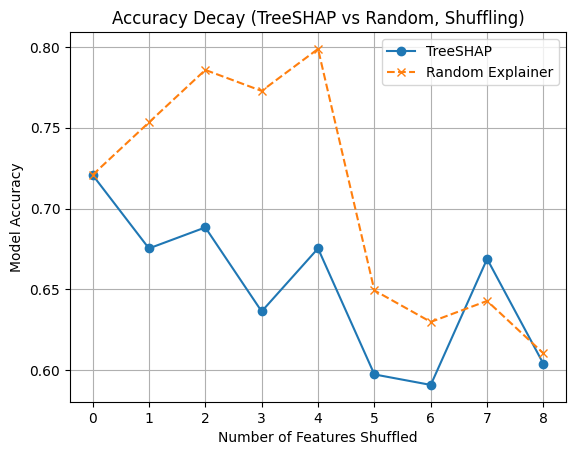

In [99]:
# Plot accuracy decay
plt.plot(range(len(acc_tree)), acc_tree, label="TreeSHAP", marker='o', linestyle='-')
plt.plot(range(len(acc_random)), acc_random, label="Random Explainer", marker='x', linestyle='--')

# Add labels and legend
plt.xlabel("Number of Features Shuffled")
plt.ylabel("Model Accuracy")
plt.title("Accuracy Decay (TreeSHAP vs Random, Shuffling)")
plt.legend()
plt.grid(True)
plt.show()

In [100]:
print(random_feature_ranking_global)
 # We actually see that BMI and BloodPressure removal increase model accuracy...
# This is just an example, we probably would need to remove zeros & outliers in the data, but it is not the purpose here

['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction', 'Pregnancies', 'Glucose', 'Age', 'BMI', 'BloodPressure']


In [101]:
roar = {"LIME": None, "KernelSHAP": None, "TreeSHAP": f7_2_tree_shap}
# This is for global methods

#### F7.3 - White box

In [3]:
# Define the linear function
def linfunc(inputs):
    """
    Linear function: Weighted sum of inputs.
    Coefficients: 0.4, 0.3, 0.2, 0.1 # just an example, it can be changed
    """
    return 0.4 * inputs[:, 0] + 0.3 * inputs[:, 1] + 0.2 * inputs[:, 2] + 0.1 * inputs[:, 3]

In [4]:
# Generate the dataset
x1 = x2 = x3 = x4 = np.linspace(0, 1, 21)  # Sequence from 0 to 1, step 0.05
pm = np.array(np.meshgrid(x1, x2, x3, x4)).T.reshape(-1, 4)  # Create the grid

# Ground-truth outputs
y = linfunc(pm)

In [5]:
np.mean(y) #average prediction --> E(X)

0.5

In [327]:
# Define instances to compare with explanations
c = np.array([[1, 0.66, 0.33, 0]])        # Specific instance
c1 = np.array([[0.5, 0.5, 0.5, 0.5]])     # All values are average
c2 = np.array([[1, 1, 1, 1]])             # All values are maximum

In [328]:
# Define the linear function coefficients
coefficients = [0.4, 0.3, 0.2, 0.1]
E_X = np.mean(y)  # 0.5 - Average prediction for all features

# Define a function to calculate feature influence
def compute_influence(coefficients, feature_values, E_X=0.5):
    """
    Compute feature influence for an instance. - from decision theory - more in https://doi-org.proxy.bnl.lu/10.1007/978-3-031-44064-9_14
    
    Parameters:
        coefficients (list): Linear coefficients for the features (w_i).
        feature_values (list): Values of the features for a given instance (x_i).
        E_X (float): Expected value of each feature (default is 0.5).
    
    Returns:
        list: Feature influence values.
    """
    return [w * x - w * E_X for w, x in zip(coefficients, feature_values)]

# Define a function to construct the table
def construct_table(instance, coefficients, xai_explanations, feature_names):
    """
    Construct a table with feature values, global importance, feature influence, and XAI coefficients.
    
    Parameters:
        instance (array): Feature values for the instance (x_i).
        coefficients (list): Linear coefficients for the features (w_i).
        xai_explanations (dict): Explanation coefficients from different XAI methods (e.g., LIME, SHAP).
        feature_names (list): Names of the features.
    
    Returns:
        DataFrame: Table summarizing the values.
    """
    # Compute feature influence
    influences = compute_influence(coefficients, instance)
    
    # Create the table
    data = {
        "Feature": feature_names,
        "Feature Value (x_i)": instance,
        "Global Importance (w_i)": coefficients,
        "Feature Influence": influences,
    }
    
    # Add XAI coefficients
    for method, explanation in xai_explanations.items():
        data[f"{method} Coefficient"] = explanation
    
    return pd.DataFrame(data)

In [329]:
# Create explainers for linear function
lime_explainer_linear = LimeTabularExplainer(pm, feature_names=["x1", "x2", "x3", "x4"], mode='regression')
kernel_shap_explainer_linear = shap.KernelExplainer(linfunc, shap.sample(pm, 1000)) # I am sampling to reduce the running time - limitation in kernelSHAP!

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [330]:
# For instance c:
lime_exp_c = lime_explainer_linear.explain_instance(c[0], linfunc)
lime_explanation_c = np.array([value for _, value in lime_exp_c.as_list()])  # Extract feature influence
shap_values_c = kernel_shap_explainer_linear.shap_values(c)
kernelshap_explanation_c = shap_values_c[0]

# For instance c1:
lime_exp_c1 = lime_explainer_linear.explain_instance(c1[0], linfunc)
lime_explanation_c1 = np.array([value for _, value in lime_exp_c1.as_list()])  # Extract feature influence
shap_values_c1 = kernel_shap_explainer_linear.shap_values(c1)
kernelshap_explanation_c1 = shap_values_c1[0]

# For instance c2:
lime_exp_c2 = lime_explainer_linear.explain_instance(c2[0], linfunc)
lime_explanation_c2 = np.array([value for _, value in lime_exp_c2.as_list()])  # Extract feature influence
shap_values_c2 = kernel_shap_explainer_linear.shap_values(c2)
kernelshap_explanation_c2 = shap_values_c2[0]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


In [331]:
feature_names = ["x1", "x2", "x3", "x4"]
# Explanation for c
xai_explanations_c = {
    "LIME": lime_explanation_c,
    "KernelSHAP": kernelshap_explanation_c
}

# Construct the table
table_c = construct_table(c[0], coefficients, xai_explanations_c, feature_names)
table_c

Feature  Feature Value (x_i)  Global Importance (w_i)  Feature Influence  \
0      x1                 1.00                      0.4              0.200   
1      x2                 0.66                      0.3              0.048   
2      x3                 0.33                      0.2             -0.034   
3      x4                 0.00                      0.1             -0.050   

   LIME Coefficient  KernelSHAP Coefficient  
0          0.205463                0.197600  
1          0.053658                0.051555  
2         -0.047043               -0.032540  
3         -0.022728               -0.049570

In [332]:
print(metrics.f7_3_compute_agreement(lime_explanation_c, table_c["Feature Influence"]))
print(metrics.f7_3_compute_agreement(kernelshap_explanation_c, table_c["Feature Influence"]))

0.76
0.97


In [333]:
# Explanation for c1
xai_explanations_c1 = {
    "LIME": lime_explanation_c1,
    "KernelSHAP": kernelshap_explanation_c1
}

# Construct the table
table_c1 = construct_table(c1[0], coefficients, xai_explanations_c1, feature_names)
table_c1

Feature  Feature Value (x_i)  Global Importance (w_i)  Feature Influence  \
0      x1                  0.5                      0.4                0.0   
1      x2                  0.5                      0.3                0.0   
2      x3                  0.5                      0.2                0.0   
3      x4                  0.5                      0.1                0.0   

   LIME Coefficient  KernelSHAP Coefficient  
0         -0.059268               -0.002400  
1         -0.036148                0.003555  
2         -0.021262                0.001460  
3         -0.018677                0.000430

In [334]:
# Explanation for c2
xai_explanations_c2 = {
    "LIME": lime_explanation_c2,
    "KernelSHAP": kernelshap_explanation_c2
}

# Construct the table
table_c2 = construct_table(c2[0], coefficients, xai_explanations_c2, feature_names)
table_c2

Feature  Feature Value (x_i)  Global Importance (w_i)  Feature Influence  \
0      x1                    1                      0.4               0.20   
1      x2                    1                      0.3               0.15   
2      x3                    1                      0.2               0.10   
3      x4                    1                      0.1               0.05   

   LIME Coefficient  KernelSHAP Coefficient  
0          0.207680                0.197600  
1          0.160529                0.153555  
2          0.101269                0.101460  
3          0.054330                0.050430

We can see that LIME and kernelSHAP are in fact computing feature influence scores (compared to the average baseline), and not feature importance scores.
Let's compare with the real feature influence scores (we can already tell that SHAP does a better job than LIME).

In [335]:
feature_names = ["x1", "x2", "x3", "x4"]

# Select 100 random indices
random_indices = np.random.choice(range(len(pm)), 100, replace=False)

# Initialize lists to store agreements
lime_agreement = []
kernel_agreement = []

for i in random_indices:
    # LIME Explanation
    lime_exp = lime_explainer_linear.explain_instance(pm[i], linfunc)
    lime_explanation = np.array([value for _, value in lime_exp.as_list()])  # Extract feature influence
    
    # KernelSHAP Explanation
    shap_values = kernel_shap_explainer_linear.shap_values(pm[i:i+1])  # KernelSHAP expects 2D input
    kernelshap_explanation = shap_values[0]  # Use the first output (assumes single target)
    
    # Construct XAI explanations dictionary
    xai_explanations = {
        "LIME": lime_explanation,
        "KernelSHAP": kernelshap_explanation
    }
    
    # Construct the table
    table = construct_table(pm[i], coefficients, xai_explanations, feature_names)
    
    # Compute agreement scores and store
    lime_agreement.append(metrics.f7_3_compute_agreement(lime_explanation, table["Feature Influence"]))
    kernel_agreement.append(metrics.f7_3_compute_agreement(kernelshap_explanation, table["Feature Influence"]))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


In [337]:
# Compute mean agreement
mean_lime_agreement = np.mean(lime_agreement)
mean_kernel_agreement = np.mean(kernel_agreement)

print(f"Mean Agreement for LIME: {mean_lime_agreement:.2f}")
print(f"Mean Agreement for KernelSHAP: {mean_kernel_agreement:.2f}")

Mean Agreement for LIME: 0.61
Mean Agreement for KernelSHAP: 0.90


Do a simple DT to evaluate treeSHAP

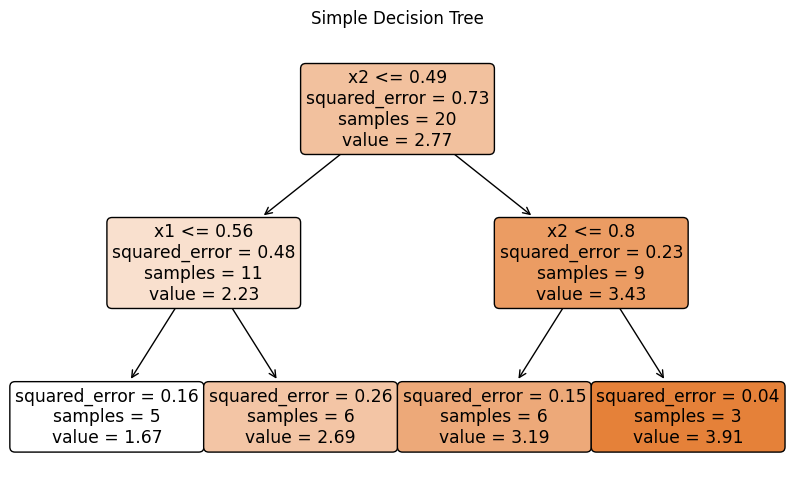

In [301]:
# Generate a simple dataset
np.random.seed(42)
X_simple = pd.DataFrame({
    "x1": np.random.rand(20),  # Random values for feature 1
    "x2": np.random.rand(20),  # Random values for feature 2
})
y_simple = 2 * X_simple["x1"] + 3 * X_simple["x2"] + np.random.rand(20)  # Random target variable

# Train a simple decision tree
simple_tree = DecisionTreeRegressor(max_depth=2, random_state=42)
simple_tree.fit(X_simple, y_simple)

# Visualize the decision tree
plt.figure(figsize=(10, 6))
plot_tree(
    simple_tree,
    feature_names=X_simple.columns,
    filled=True,
    rounded=True,
    precision=2
)
plt.title("Simple Decision Tree")
plt.show()

In [320]:
# 3. Compute TreeSHAP explanations
tree_explainer = shap.TreeExplainer(simple_tree)
shap_values_tree = tree_explainer(X_simple)
# Calculate mean absolute Shapley values for each feature
global_shap_tree = np.mean(np.abs(shap_values.values), axis=0)
simple_tree_coefs = simple_tree.feature_importances_

# Compute agreement
tree_shap_agreement = metrics.f7_3_compute_agreement(global_shap_tree, simple_tree_coefs)
print(f"Agreement for treeSHAP: {tree_shap_agreement}")

Agreement for treeSHAP: 0.89


In [350]:
white_box = {"LIME": metrics.f7_3_score(mean_lime_agreement), "KernelSHAP": metrics.f7_3_score(mean_kernel_agreement), "TreeSHAP": metrics.f7_3_score(tree_shap_agreement)}

#### F7 Summary Table

In [345]:
# Calculate total scores - not including ROAR here, comparing all local methods
total_faithfulness = {key: incremental_deletion[key] + white_box[key] for key in incremental_deletion}

In [346]:
f7 = pd.DataFrame({
    "Incremental Deletion (F7.1)": [incremental_deletion["LIME"], incremental_deletion["KernelSHAP"], incremental_deletion["TreeSHAP"]],
    "ROAR (F7.2)": [roar["LIME"], roar["KernelSHAP"], roar["TreeSHAP"]],
    "White-Box Check (F7.3)": [white_box["LIME"], white_box["KernelSHAP"], white_box["TreeSHAP"]],
    "Total": [total_faithfulness["LIME"], total_faithfulness["KernelSHAP"], total_faithfulness["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f7

Incremental Deletion (F7.1)  ROAR (F7.2)  White-Box Check (F7.3)  \
LIME                                0.4          NaN                       1   
KernelSHAP                          0.5          NaN                       2   
TreeSHAP                            0.5          0.1                       2   

            Total  
LIME          1.4  
KernelSHAP    2.5  
TreeSHAP      2.5

### F8 - Truthfulness

#### F8.1 - Reality Check 
(fixed)

F8.1A

LIME and kernel SHAP generate synthetic samples for perturbations using the training data's distribution, helping to maintain valid ranges for individual features.

TreeSHAP uses the structure of the tree-based model to calculate SHAP values, ensuring explanations are directly tied to the model’s learned decision boundaries. This inherently respects feature constraints defined in the training data.

In [36]:
reality_check_A = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}

F8.1B

C:\Users\dcanha\AppData\Local\Temp\ipykernel_16048\3068011958.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


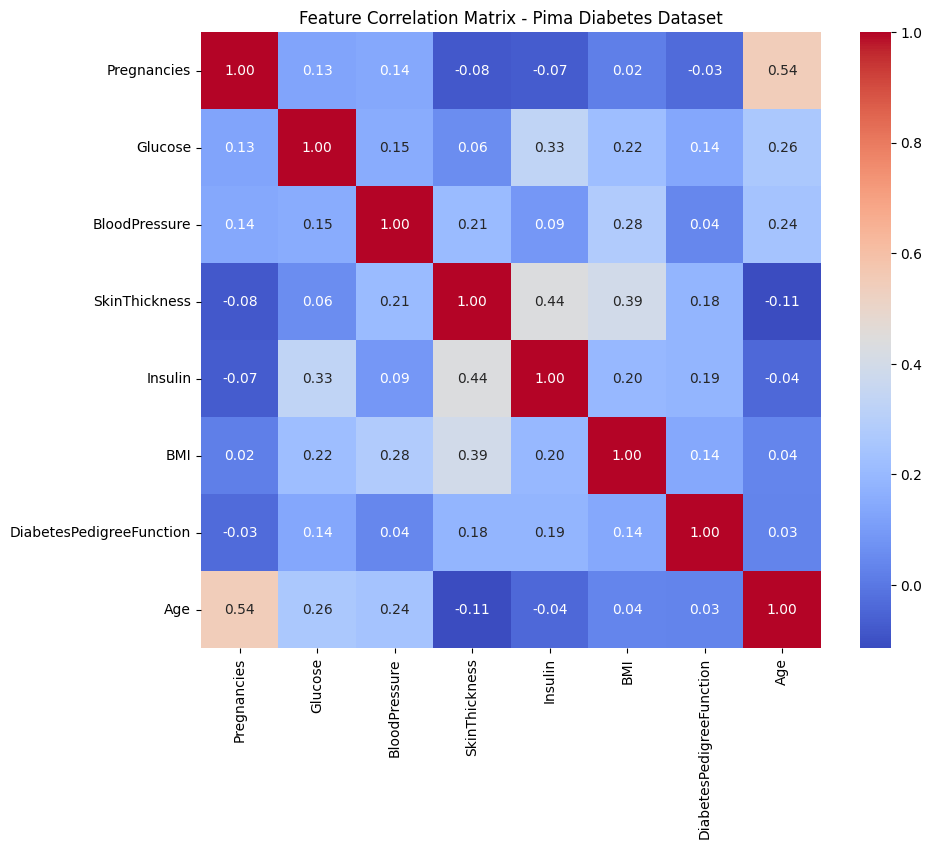

In [37]:
# Calculate correlations
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix - Pima Diabetes Dataset")
plt.show()

LIME and kernelSHAP assume feature independence when perturbing input data. It does not account for correlations between features, such as age and nb pregnancies, producing unrealistic combinations.

TreeSHAP respects feature correlations as captured by the tree-based model. If the model itself captures feature dependencies, TreeSHAP explanations will reflect these relationships.

In [35]:
reality_check_B = {"LIME": 0, "KernelSHAP": 0, "TreeSHAP": 1}

In [38]:
reality_check = {"LIME": reality_check_A["LIME"] + reality_check_B["LIME"], 
                 "KernelSHAP": reality_check_A["KernelSHAP"] + reality_check_B["KernelSHAP"], 
                 "TreeSHAP": reality_check_A["TreeSHAP"] + reality_check_B["TreeSHAP"]}

#### F8.2 - Bias Detection

In [150]:
# Generate a synthetic dataset for efficient bias detection
from sklearn.datasets import make_classification

# Generate synthetic data with clear biases
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,       # Number of samples
    n_features=5,         # Number of features
    n_informative=3,      # Number of informative features
    n_redundant=1,        # Number of redundant features
    n_clusters_per_class=1, random_state=42
)

# Convert to a DataFrame for manipulation
synthetic_data = pd.DataFrame(X_synthetic, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])
synthetic_data['Outcome'] = y_synthetic

# Introduce a demographic feature and inject bias
synthetic_data['Demographic'] = np.random.choice(['Group_A', 'Group_B'], size=1000, p=[0.7, 0.3])
synthetic_data.loc[
    (synthetic_data['Demographic'] == 'Group_A') & (synthetic_data['Feature1'] > 0), 'Outcome'] = 1

# Encode the demographic feature for modeling
synthetic_data['Demographic_encoded'] = synthetic_data['Demographic'].map({'Group_A': 0, 'Group_B': 1})

# Inspect the resulting dataset
synthetic_summary = synthetic_data.groupby('Demographic')['Outcome'].mean()
synthetic_data.head(), synthetic_summary

(   Feature1  Feature2  Feature3  Feature4  Feature5  Outcome Demographic  \
 0  0.481210  0.269386  1.496879  1.651237  1.075099        1     Group_A   
 1  0.311062  0.780386 -1.451478  1.723465 -0.874689        0     Group_B   
 2 -1.092120 -1.140347  0.258995  0.898648 -0.474031        0     Group_A   
 3  0.111132  1.171272 -0.322178 -1.970000 -1.173218        1     Group_A   
 4  0.252584  0.629103  0.927478  0.743902  0.107253        1     Group_A   
 
    Demographic_encoded  
 0                    0  
 1                    1  
 2                    0  
 3                    0  
 4                    0  ,
 Demographic
 Group_A    0.871287
 Group_B    0.443686
 Name: Outcome, dtype: float64)

C:\Users\dcanha\AppData\Local\Temp\ipykernel_16048\824381847.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=synthetic_data, x="Demographic", y="Outcome", ci=None, palette="coolwarm")
C:\Users\dcanha\AppData\Local\Temp\ipykernel_16048\824381847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=synthetic_data, x="Demographic", y="Outcome", ci=None, palette="coolwarm")


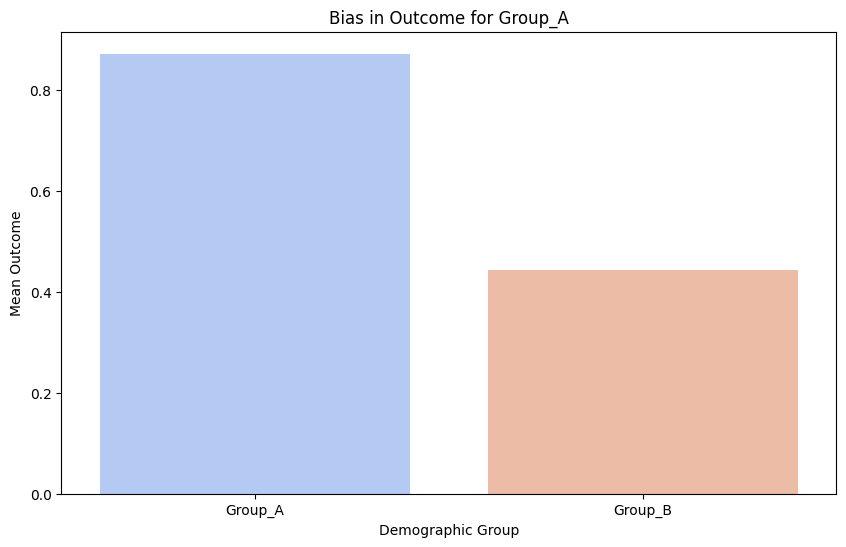

In [151]:
# Visualize bias in the dataset
plt.figure(figsize=(10, 6))
sns.barplot(data=synthetic_data, x="Demographic", y="Outcome", ci=None, palette="coolwarm")
plt.title("Bias in Outcome for Group_A")
plt.xlabel("Demographic Group")
plt.ylabel("Mean Outcome")
plt.show()

In [152]:
# Prepare the data for training
X_bias = synthetic_data[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Demographic_encoded']]
y_bias = synthetic_data['Outcome']
X_train_bias, X_test_bias, y_train_bias, y_test_bias = train_test_split(X_bias, y_bias, test_size=0.2, random_state=42)

In [153]:
# Train a Random Forest model_biased
model_biased = RandomForestClassifier(random_state=42)
model_biased.fit(X_train_bias, y_train_bias)
accuracy = model_biased.score(X_test_bias, y_test_bias)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.97


In [154]:
# Initialize LIME
lime_explainer_bias = LimeTabularExplainer(X_train_bias.values, mode='classification', training_labels=y_train_bias, feature_names=X_bias.columns,
                                      class_names=['No', 'Yes'])
# Initialize SHAP for biased model
kernel_shap_explainer_bias = shap.KernelExplainer(model_biased.predict_proba, X_train_bias) # the warning is coming from here, because kernelSHAP is slow
tree_shap_explainer_bias = shap.TreeExplainer(model_biased)

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [157]:
X_test_bias.iloc[2]


Feature1               1.065843
Feature2               2.422918
Feature3              -1.616210
Feature4               0.153102
Demographic_encoded    0.000000
Name: 740, dtype: float64

In [159]:
# Lime explanation
lime_explanation = lime_explainer_bias.explain_instance(X_test_bias.iloc[2].values, model_biased.predict_proba)
lime_explanation.show_in_notebook()

c:\Users\dcanha\AppData\Local\R-MINI~1\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [161]:
instance = X_test_bias.iloc[2].values.reshape(1, -1)
# Kernel SHAP explanation
kernel_shap_values = kernel_shap_explainer_bias(instance)
shap.initjs()
# Showing explanation for diabetes probability
shap.force_plot(kernel_shap_explainer_bias.expected_value[1], kernel_shap_values.values[:,:,1], instance, feature_names=X_bias.columns)

100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


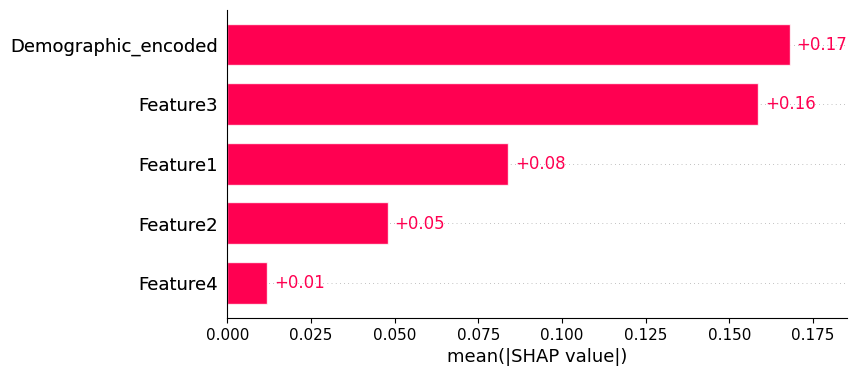

In [162]:
# Get global explanation
shap_values_global = tree_shap_explainer_bias(X_train_bias)
shap.plots.bar(shap_values_global[:,:,1])

Both LIME and SHAP (KernelSHAP and TreeSHAP) successfully exposed the bias in the model. The prominence of Demographic_encoded in the explanations makes the bias clear and measurable.

In [163]:
bias_detection = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}

#### F6 Summary Table

In [164]:
# Calculate total scores
total_truth = {key: reality_check[key] + bias_detection[key] for key in reality_check}

In [165]:
f8 = pd.DataFrame({
    "Reality Check (F8.1)": [reality_check["LIME"], reality_check["KernelSHAP"], reality_check["TreeSHAP"]],
    "Bias Detection (F8.2)": [bias_detection["LIME"], bias_detection["KernelSHAP"], bias_detection["TreeSHAP"]],
    "Total": [total_truth["LIME"], total_truth["KernelSHAP"], total_truth["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f8

Reality Check (F8.1)  Bias Detection (F8.2)  Total
LIME                           1                      1      2
KernelSHAP                     1                      1      2
TreeSHAP                       2                      1      3

### F9 - Stability

#### F9.1 - Similarity

First find neighbors - implementation taken from Python library "shapash"

In [20]:
# Select first 30 indices (N=30)
selection = list(X_train.index[0:30])

all_neighbors = metrics.find_neighbors(
    selection=selection,  # Example: indices of selected instances
    dataset=X_train,      # Feature dataset
    model=model,          # Trained model
    mode="classification", # Model task
    n_neighbors=5 # Select number of neighbors n
)

In [21]:
neighbors_input = metrics.prepare_neighbors(all_neighbors, X_train.columns)

In [22]:
exp_list_lime = []
exp_list_kernel = []
exp_list_tree = []
# Iterate over neighbors to compute explanations for each instance with more than one neighbor
for i, instance_neighbors in enumerate(neighbors_input):
    if len(instance_neighbors) > 1:

        instance_explanations_lime = []
        instance_explanations_kernel = []
        instance_explanations_tree = []

        for neighbor in instance_neighbors:
            # Compute LIME explanation for each neighbor
            exp_lime = lime_explainer.explain_instance(neighbor, model.predict_proba)
            # Extract the explanation values and append to the instance_explanations list
            instance_explanations_lime.append([v for _, v in exp_lime.as_list()])

            # Compute kernelSHAP explanation for each neighbor
            exp_kernel = kernel_shap_explainer(neighbor)
            # Extract the explanation values and append to the instance_explanations list
            instance_explanations_kernel.append(exp_kernel.values[:,1])

            # Compute treeSHAP explanation for each neighbor
            exp_tree = tree_shap_explainer(neighbor)
            # Extract the explanation values and append to the instance_explanations list
            instance_explanations_tree.append(exp_tree.values[:,1])
            
        # Append the list of explanations for this instance to the main list
        exp_list_lime.append(instance_explanations_lime)
        exp_list_kernel.append(instance_explanations_kernel)
        exp_list_tree.append(instance_explanations_tree)

In [23]:
len(exp_list_lime)
# We only have 25 instances, as 5 had no neighbors, let's proceed with this number

26

In [112]:
similarity = {"LIME": metrics.f9_score(exp_list_lime, euclidean), 
              "KernelSHAP": metrics.f9_score(exp_list_kernel, euclidean), 
              "TreeSHAP": metrics.f9_score(exp_list_tree, euclidean)}

In [113]:
similarity

{'LIME': 0.2, 'KernelSHAP': 0.2, 'TreeSHAP': 0.2}

#### F9.1 - Identity

In [45]:
exp_list_lime_ = []
exp_list_kernel_ = []
exp_list_tree_ = []

# Choosing the first 30 instances of the test set
N = 30
# Choose how many repetitions we want
r = 10

# Iterate over instances to compute explanations for each instance multiple times
for i in range(N):
    # Initialize lists to hold repeated explanations for this instance
    instance_explanations_lime = []
    instance_explanations_kernel = []
    instance_explanations_tree = []

    for j in range(r):
        # Compute LIME explanation
        exp_lime = lime_explainer.explain_instance(X_test.values[i], model.predict_proba)
        # Extract the explanation values and append to the instance_explanations list
        instance_explanations_lime.append([v for _, v in exp_lime.as_list()])

        # Compute kernelSHAP explanation
        exp_kernel = kernel_shap_explainer(X_test.values[i])
        # Extract the explanation values and append to the instance_explanations list
        instance_explanations_kernel.append(exp_kernel.values[:, 1])

        # Compute treeSHAP explanation
        exp_tree = tree_shap_explainer(X_test.values[i])
        # Extract the explanation values and append to the instance_explanations list
        instance_explanations_tree.append(exp_tree.values[:, 1])

    # Append the list of explanations for this instance to the main list
    exp_list_lime_.append(instance_explanations_lime)    
    exp_list_kernel_.append(instance_explanations_kernel) 
    exp_list_tree_.append(instance_explanations_tree)     

In [46]:
len(exp_list_lime_)

30

In [110]:
identity = {"LIME": metrics.f9_score(exp_list_lime_, euclidean, metric= "identity"), 
              "KernelSHAP": metrics.f9_score(exp_list_kernel_, euclidean, metric= "identity"), 
              "TreeSHAP": metrics.f9_score(exp_list_tree_, euclidean, metric= "identity")}

In [111]:
identity

{'LIME': 0.1, 'KernelSHAP': 1.0, 'TreeSHAP': 1.0}

Where Pairwise Distance Doesn’t Work we use the second case (see paper): Counterfactual explanations, rule-based methods (e.g., Anchors), and methods working with non-numeric or categorical data.

For example:
 - Counterfactuals: Compute the variability in suggested changes (e.g., which features are modified, and by how much).
 - Anchors: Use the variance-to-mean ratio to evaluate the stability of rules across similar instances.

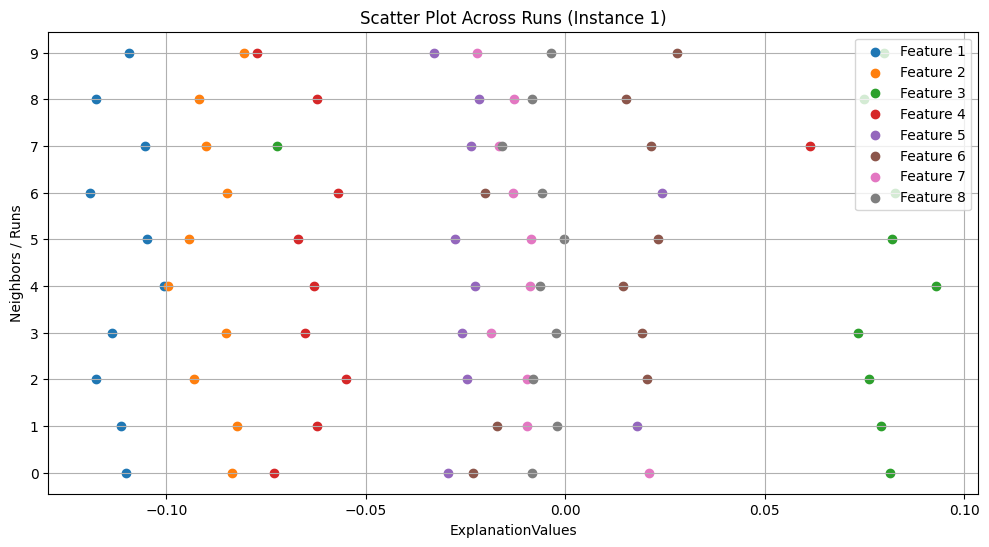

In [ ]:
# LIME plot for identity
metrics.scatter_feature_values(exp_list_lime_, instance_idx = [1], metric="identity")

We see how LIME values do not stay the same for the SAME INSTANCE across several runs. They even change signs (e.g. feature 5 and 7). This is problematic.

The same does not happen for kernelSHAP (or treeSHAP) - see below.

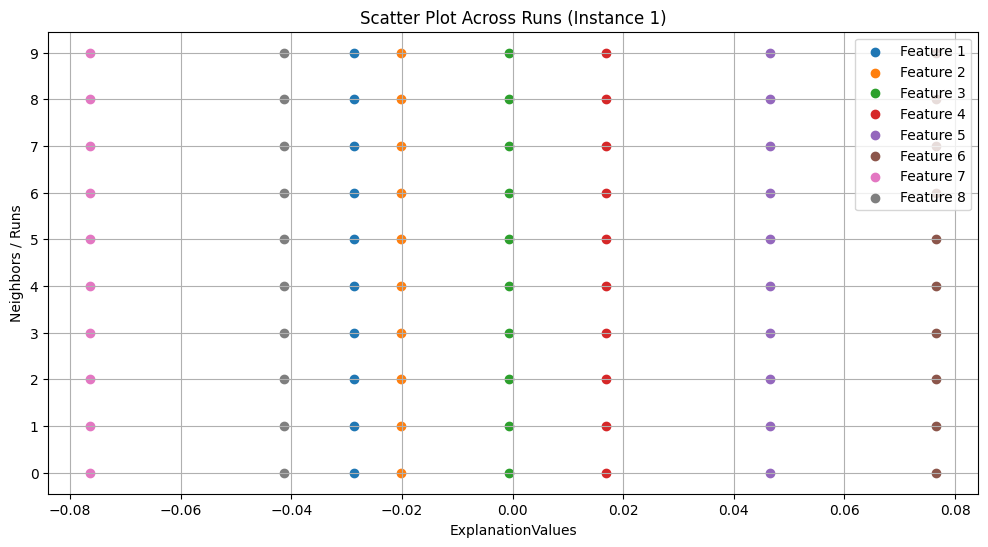

In [ ]:
# kernelSHAP plot for identity
metrics.scatter_feature_values(exp_list_kernel_, instance_idx = [1], metric="identity")

### F10 - Certainty

In [182]:
c1 = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# All methods report confidence in the black-box model's output - display the probability of the outcome (for classification)
c2 = {"LIME": 0, "KernelSHAP": 0, "TreeSHAP": 0}
# None of them report explanation confidence values
c3 = {"LIME": 0, "KernelSHAP": 0, "TreeSHAP": 1}
# LIME and kernelSHAP are not deterministic, and this is not disclosured with the explanation
c4 = {"LIME": 0, "KernelSHAP": 0, "TreeSHAP": 0}
# None of them shows instance distribution relatively to training set
c5 = {"LIME": 1, "KernelSHAP": 1, "TreeSHAP": 1}
# LIME can indicate the r2 score, even it is bad it shows the "wrong" explanation
# kernelSHAP provides kernel weights
# treeSHAP displays feature perturbation method

In [183]:
# Combine all into a list of dictionaries
categories = [c1, c2, c3, c4, c5]

# Sum up values for each method
final_metric = {key: sum(cat.get(key, 0) for cat in categories) for key in c1.keys()}

f10 = pd.DataFrame({
    "Total": [final_metric["LIME"], final_metric["KernelSHAP"], final_metric["TreeSHAP"]]
}, index=["LIME", "KernelSHAP", "TreeSHAP"])
f10



Total
LIME            2
KernelSHAP      2
TreeSHAP        3

### F11 - Speed